In [ ]:
#폐렴아 기다려(MainQuest3)

In [27]:
#<개요>
#1. 데이터 불러오기
#2. 데이터 전처리
#3. 데이터 시각화
#4. CNN 모델링
#5. 데이터 imbalance 처리
#6. 모델훈련
#7. 결과확인

In [ ]:
#채점기준
#채점 기준 (총 5점)
#프로젝트 제출 : 1점
#루브릭 : 4점
#의료영상을 처리하는 CNN 기반 베이스 모델 구현 -1점
#데이터 augmentation 기법을 사용해서 베이스 모델과의 성능을 비교 - 1점
#모델 구조 변경을 통해 베이스 모델과의 성능 비교 - 1점
#ResNet-18 모델을 구현하고 학습 성공 - 1점

#※ 보고서 양식 (개요, 목차, 주석 및 의견, summary, 회고, reference 등)이 포함되어 있지 않을 경우 감점 1점

In [ ]:
#1. 데이터 불러오기

In [1]:
! mkdir -p ~/aiffel/chest_xray
! ln -s ~/data/ ~/aiffel/chest_xray

ln: failed to create symbolic link '/aiffel/aiffel/chest_xray/data': File exists


In [2]:
#2. 기본설정과 라이브러리 임포트 단계

In [3]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [4]:
#3. 데이터 시각화

In [5]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [6]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [7]:
#cnn모델 구현

In [8]:
from tensorflow.keras import layers, models

def cnn_model(input_shape=(224, 224, 1)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # 이진 분류용
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',  # 쉼표 추가
                  metrics=['accuracy'])  # 쉼표 수정

    return model

# 모델 생성 및 요약 출력
model = cnn_model()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0

In [9]:
#모델 생성

In [10]:
from tensorflow.keras import layers, models

def build_cnn_base_model(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # 이진 분류용
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [11]:
# CNN 모델 생성
cnn_model = build_cnn_base_model()

# 모델 요약 출력
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)           

In [12]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [13]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [14]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [15]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [16]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [17]:
#4. CNN 모델링

In [18]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [19]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [20]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [21]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [22]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [23]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

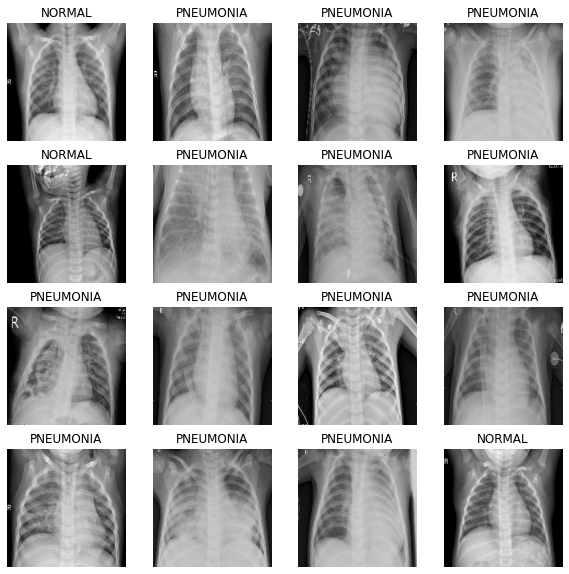

In [24]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [25]:
#5. 데이터 imbalance 처리

In [26]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [27]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [28]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [29]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [30]:
#6. 모델훈련

In [31]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [32]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 66s 202ms/step - loss: 0.5188 - accuracy: 0.7486 - precision: 0.9227 - recall: 0.7226 - val_loss: 0.6062 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 200ms/step - loss: 0.2559 - accuracy: 0.8982 - precision: 0.9726 - recall: 0.8886 - val_loss: 0.8959 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 203ms/step - loss: 0.2232 - accuracy: 0.9145 - precision: 0.9708 - recall: 0.9123 - val_loss: 0.8225 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 53s 204ms/step - loss: 0.1966 - accuracy: 0.9248 - precision: 0.9772 - recall: 0.9207 - val_loss: 0.3338 - val_accuracy: 0.8769 - val_precision: 0.9984 - val_recall: 0.8338
Epoch 5/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1944 - accura

In [39]:
#Resnet 구현

In [44]:
import os

# 데이터 경로 설정
data_dir = os.path.expanduser('~/aiffel/chest_xray/data')

# 경로 확인
print("데이터셋 디렉토리 내용:", os.listdir(data_dir))

데이터셋 디렉토리 내용: ['val', 'train', 'test']


In [45]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 이미지 전처리
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 데이터셋 불러오기
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 클래스 확인
print("클래스 라벨:", train_dataset.classes)  # ['NORMAL', 'PNEUMONIA']
print("훈련 데이터 크기:", len(train_dataset))
print("검증 데이터 크기:", len(val_dataset))
print("테스트 데이터 크기:", len(test_dataset))


클래스 라벨: ['NORMAL', 'PNEUMONIA']
훈련 데이터 크기: 5216
검증 데이터 크기: 16
테스트 데이터 크기: 624


In [ ]:
#데이터 증강기법을 통해 베이스 모델과 성능 비교

In [55]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

# 데이터 경로
data_dir = os.path.expanduser('~/aiffel/chest_xray/data')

# 1. 데이터 전처리 (베이스 모델 - 증강 없음)
base_train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 2. 데이터 전처리 (증강 모델)
augmented_train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),          # 수평 반전
    transforms.RandomRotation(15),              # 랜덤 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기/대비 조절
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 이동
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 테스트/검증 데이터는 동일한 전처리 적용
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 데이터셋 불러오기
base_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=base_train_transforms)
augmented_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=augmented_train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

# DataLoader 생성
base_train_loader = DataLoader(base_train_dataset, batch_size=32, shuffle=True)
augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 클래스 확인
class_names = base_train_dataset.classes
print(f"클래스 라벨: {class_names}")  # ['NORMAL', 'PNEUMONIA']


사용 중인 디바이스: cuda
클래스 라벨: ['NORMAL', 'PNEUMONIA']


In [56]:
# ResNet-18 모델 생성 함수
def create_resnet18():
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)  # 이진 분류
    return model.to(device)

# 모델 학습 함수
def train_model(model, train_loader, val_loader, epochs=5):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # 검증 단계
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs) > 0.5
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [57]:
EPOCHS = 10

# 1. 베이스 모델 학습
print("==== 베이스 모델 학습 (증강 없음) ====")
base_model = create_resnet18()
base_train_losses, base_val_losses, base_train_accs, base_val_accs = train_model(
    base_model, base_train_loader, val_loader, epochs=EPOCHS
)

# 2. 증강 모델 학습
print("\n==== 증강 모델 학습 (데이터 증강 적용) ====")
augmented_model = create_resnet18()
aug_train_losses, aug_val_losses, aug_train_accs, aug_val_accs = train_model(
    augmented_model, augmented_train_loader, val_loader, epochs=EPOCHS
)


==== 베이스 모델 학습 (증강 없음) ====
Epoch 1/10, Train Loss: 0.1110, Train Acc: 95.65%, Val Loss: 0.5052, Val Acc: 75.00%
Epoch 2/10, Train Loss: 0.0620, Train Acc: 97.62%, Val Loss: 0.2630, Val Acc: 87.50%
Epoch 3/10, Train Loss: 0.0515, Train Acc: 98.10%, Val Loss: 1.0920, Val Acc: 68.75%
Epoch 4/10, Train Loss: 0.0393, Train Acc: 98.60%, Val Loss: 1.1073, Val Acc: 68.75%
Epoch 5/10, Train Loss: 0.0327, Train Acc: 98.95%, Val Loss: 0.1059, Val Acc: 93.75%
Epoch 6/10, Train Loss: 0.0310, Train Acc: 98.93%, Val Loss: 0.1201, Val Acc: 87.50%
Epoch 7/10, Train Loss: 0.0213, Train Acc: 99.27%, Val Loss: 0.3208, Val Acc: 87.50%
Epoch 8/10, Train Loss: 0.0217, Train Acc: 99.21%, Val Loss: 0.0892, Val Acc: 93.75%
Epoch 9/10, Train Loss: 0.0212, Train Acc: 99.35%, Val Loss: 1.1980, Val Acc: 75.00%
Epoch 10/10, Train Loss: 0.0113, Train Acc: 99.71%, Val Loss: 0.6377, Val Acc: 81.25%

==== 증강 모델 학습 (데이터 증강 적용) ====
Epoch 1/10, Train Loss: 0.1579, Train Acc: 93.96%, Val Loss: 1.1555, Val Acc: 75.00%
Epoc

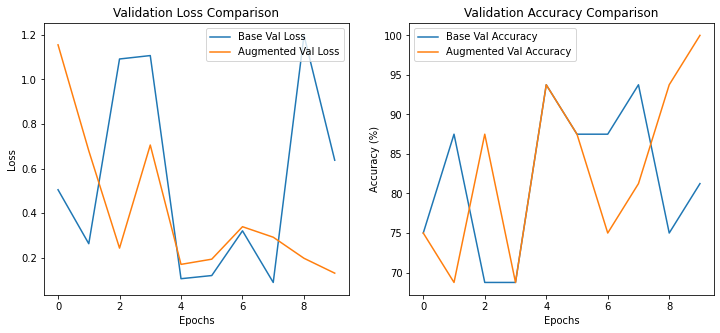

In [58]:
# 손실 비교 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), base_val_losses, label='Base Val Loss')
plt.plot(range(EPOCHS), aug_val_losses, label='Augmented Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')
plt.legend()

# 정확도 비교 그래프
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), base_val_accs, label='Base Val Accuracy')
plt.plot(range(EPOCHS), aug_val_accs, label='Augmented Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Comparison')
plt.legend()

plt.show()


In [59]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

# 데이터 경로
data_dir = os.path.expanduser('~/aiffel/chest_xray/data')

# 데이터 전처리
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 데이터셋 불러오기
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 클래스 확인
class_names = train_dataset.classes
print(f"클래스 라벨: {class_names}")  # ['NORMAL', 'PNEUMONIA']


사용 중인 디바이스: cuda
클래스 라벨: ['NORMAL', 'PNEUMONIA']


In [60]:
# ResNet-18 생성 함수
def create_resnet18():
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)  # 이진 분류
    return model.to(device)

# ResNet-50 생성 함수 (변경된 모델)
def create_resnet50():
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)  # 이진 분류
    return model.to(device)


In [61]:
# ResNet-18 생성 함수
def create_resnet18():
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)  # 이진 분류
    return model.to(device)

# ResNet-50 생성 함수 (변경된 모델)
def create_resnet50():
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 1)  # 이진 분류
    return model.to(device)


In [62]:
# 모델 학습 함수
def train_model(model, train_loader, val_loader, epochs=5):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # 검증 단계
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs) > 0.5
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:
EPOCHS = 10

# 1. ResNet-18 학습 (베이스 모델)
print("==== ResNet-18 학습 ====")
resnet18_model = create_resnet18()
res18_train_losses, res18_val_losses, res18_train_accs, res18_val_accs = train_model(
    resnet18_model, train_loader, val_loader, epochs=EPOCHS
)

# 2. ResNet-50 학습 (구조 변경 모델)
print("\n==== ResNet-50 학습 ====")
resnet50_model = create_resnet50()
res50_train_losses, res50_val_losses, res50_train_accs, res50_val_accs = train_model(
    resnet50_model, train_loader, val_loader, epochs=EPOCHS
)


==== ResNet-18 학습 ====
Epoch 1/10, Train Loss: 0.1210, Train Acc: 95.44%, Val Loss: 0.3757, Val Acc: 62.50%
Epoch 2/10, Train Loss: 0.0673, Train Acc: 97.62%, Val Loss: 0.0997, Val Acc: 100.00%
Epoch 3/10, Train Loss: 0.0533, Train Acc: 97.91%, Val Loss: 0.7162, Val Acc: 68.75%
Epoch 4/10, Train Loss: 0.0590, Train Acc: 97.87%, Val Loss: 0.0304, Val Acc: 100.00%
Epoch 5/10, Train Loss: 0.0482, Train Acc: 98.29%, Val Loss: 0.2463, Val Acc: 87.50%
Epoch 6/10, Train Loss: 0.0343, Train Acc: 98.81%, Val Loss: 0.2921, Val Acc: 81.25%
Epoch 7/10, Train Loss: 0.0440, Train Acc: 98.27%, Val Loss: 0.8895, Val Acc: 68.75%
Epoch 8/10, Train Loss: 0.0330, Train Acc: 98.87%, Val Loss: 0.0334, Val Acc: 100.00%
Epoch 9/10, Train Loss: 0.0207, Train Acc: 99.27%, Val Loss: 0.0937, Val Acc: 100.00%
Epoch 10/10, Train Loss: 0.0179, Train Acc: 99.27%, Val Loss: 0.2842, Val Acc: 81.25%

==== ResNet-50 학습 ====


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /aiffel/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1/10, Train Loss: 0.1430, Train Acc: 94.77%, Val Loss: 0.4166, Val Acc: 75.00%
Epoch 2/10, Train Loss: 0.0887, Train Acc: 96.80%, Val Loss: 0.1490, Val Acc: 100.00%


In [ ]:
# 손실 비교 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), res18_val_losses, label='ResNet-18 Val Loss')
plt.plot(range(EPOCHS), res50_val_losses, label='ResNet-50 Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')
plt.legend()

# 정확도 비교 그래프
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), res18_val_accs, label='ResNet-18 Val Accuracy')
plt.plot(range(EPOCHS), res50_val_accs, label='ResNet-50 Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Comparison')
plt.legend()

plt.show()


In [ ]:
# 테스트 데이터셋 평가 함수
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_acc = 100 * correct / total
    return test_acc

# ResNet-18 테스트 정확도
res18_test_acc = evaluate_model(resnet18_model, test_loader)
print(f"ResNet-18 테스트 정확도: {res18_test_acc:.2f}% ✅")

# ResNet-50 테스트 정확도
res50_test_acc = evaluate_model(resnet50_model, test_loader)
print(f"ResNet-50 테스트 정확도: {res50_test_acc:.2f}% ✅")


In [ ]:
#Resnet 모델

In [46]:
!ls -l ~/aiffel/chest_xray

total 0
lrwxrwxrwx 1 root root 13 Feb 17 02:05 data -> /aiffel/data/


In [48]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

사용 중인 디바이스: cuda


In [49]:
# 데이터 경로 설정
data_dir = os.path.expanduser('~/aiffel/chest_xray/data')

# 이미지 전처리 (훈련 데이터에 데이터 증강 포함)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 데이터셋 불러오기
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=test_transforms)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 클래스 확인
class_names = train_dataset.classes
print(f"클래스 라벨: {class_names}")  # ['NORMAL', 'PNEUMONIA']

클래스 라벨: ['NORMAL', 'PNEUMONIA']


In [50]:
# 사전 학습된 ResNet-18 불러오기
model = models.resnet18(pretrained=True)

# 출력층 수정 (이진 분류: NORMAL vs PNEUMONIA)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # 이진 분류이므로 출력 노드 1개

# 모델을 디바이스에 할당
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /aiffel/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [51]:
# 손실 함수: BCEWithLogitsLoss (이진 분류용)
criterion = nn.BCEWithLogitsLoss()

# 옵티마이저: Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습률 스케줄러 (선택 사항)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [52]:
EPOCHS = 10  # 에폭 수

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # 훈련 루프
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)  # BCEWithLogitsLoss에 맞게 조정

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # 검증 루프
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/10, Train Loss: 0.1220, Train Acc: 95.17%, Val Loss: 0.3382, Val Acc: 81.25%
Epoch 2/10, Train Loss: 0.0707, Train Acc: 97.47%, Val Loss: 0.4535, Val Acc: 75.00%
Epoch 3/10, Train Loss: 0.0668, Train Acc: 97.57%, Val Loss: 0.5416, Val Acc: 68.75%
Epoch 4/10, Train Loss: 0.0577, Train Acc: 98.08%, Val Loss: 0.3191, Val Acc: 87.50%
Epoch 5/10, Train Loss: 0.0433, Train Acc: 98.33%, Val Loss: 0.9102, Val Acc: 81.25%
Epoch 6/10, Train Loss: 0.0274, Train Acc: 98.95%, Val Loss: 0.2380, Val Acc: 81.25%
Epoch 7/10, Train Loss: 0.0161, Train Acc: 99.56%, Val Loss: 0.3203, Val Acc: 75.00%
Epoch 8/10, Train Loss: 0.0132, Train Acc: 99.58%, Val Loss: 0.1430, Val Acc: 100.00%
Epoch 9/10, Train Loss: 0.0120, Train Acc: 99.73%, Val Loss: 0.0808, Val Acc: 100.00%
Epoch 10/10, Train Loss: 0.0089, Train Acc: 99.71%, Val Loss: 0.1261, Val Acc: 93.75%


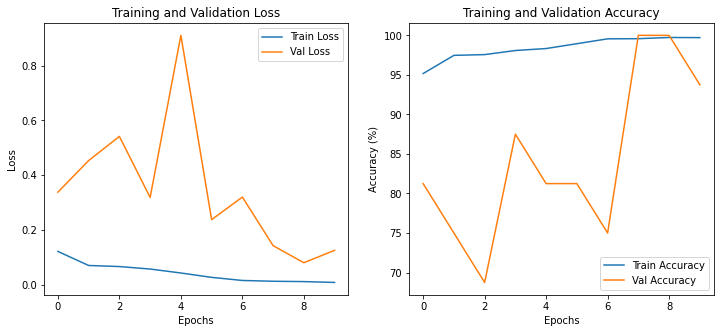

In [53]:
# 손실 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), train_losses, label='Train Loss')
plt.plot(range(EPOCHS), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), train_accuracies, label='Train Accuracy')
plt.plot(range(EPOCHS), val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


In [54]:
# 테스트 데이터셋 평가
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"테스트 정확도: {test_acc:.2f}% ✅")


테스트 정확도: 74.36% ✅


In [ ]:
#7. 결과확인

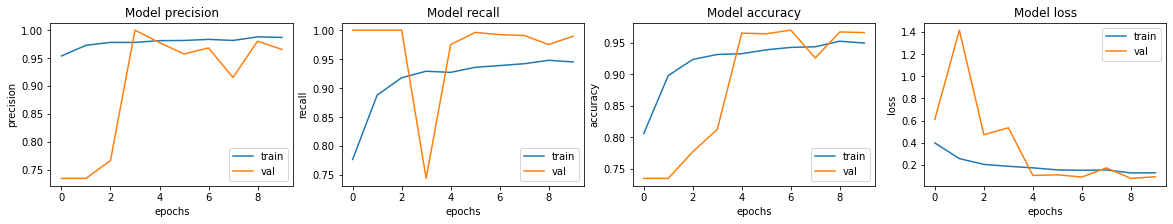

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# 메인퀘스트 03 수행 보고서
# 개요, 목차, 주석 및 의견, summary, 회고, reference 등

In [ ]:
# 개요
# 의료데이터 활용하여 ResNet 구현해보기
# 목차
# 1. 소스코드
# 2. 결과
# 3. 보고서

In [ ]:
#주석 및 의견
#주석의 대부분은 LMS에서 발췌, 의견으로는 아직까지 코드를 보는 것이 어렵습니다. 하지만 스스로의 힘으로 무언가를 완성시키는 것에  
#성취감과 완결감이 느껴지기에 꾸역꾸역 열심히 따라가고 있습니다.
#코드를 보는 것이 서툴고 어렵습니다.

In [ ]:
#summary
#의료현장에서 폐사진을 어떻게 효과적을 활용할지에 대한 딥러닝 모델 구현

In [28]:
#회고
#몇몇개를 Chat GPT 없이 해보려니 무척 어려웠다. 일단 개념부터 이해하기 어려웠고, 코드를 치는 것도 무척 어려웠다.
#2010년대에는 스티브 잡스의 영향으로 디자인 등 문과가 각광을 받았으나, 최근 경기불황으로 이과의 기술이 떠오르고 있다.
#이런 상황에서 이과도 잘했지만 문과를 갔던 사람으로써 약간의 자격지심과 열등감이 느껴진다.
#전체적인 시스템을 파악하는데만 특기인 사람이다. 그러므로 코드를 치는 것은 자잘하면서도 엄청나다고 느껴져셔 감히 시도를 못하겠다.
#이번 퀘스트를 바탕으로 좀 더 다른 쪽의 뇌를 쓰고, 자잘하고 치졸하다고 느껴지는 코드치기도 모두 해봐야겠다.
#사실 어깨가 말리고 거북목이 될까봐 너무 무섭지만, 운동과 의지 가능성으로 도전하고 극복하려고 한다.

In [ ]:
# Reference
# 아이펠 LMS - http://lms.aiffel.io/